# K-Means , Agglomerative and DBSCAN on Amazon Fine Food Reviews DataSet:

# Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

##### The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

###### Number of reviews: 568,454
###### Number of users: 256,059
###### Number of products: 74,258
###### Timespan: Oct 1999 - Oct 2012
###### Number of Attributes/Columns in data: 10

###### Attribute Information:

###### Id - Id of the row in the dataset
###### ProductId - unique identifier for the product
###### UserId - unqiue identifier for the user
###### ProfileName - name on the profile
###### HelpfulnessNumerator - number of users who found the review helpful
###### HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
###### Score - rating between 1 and 5
###### Time - timestamp for the review
###### Summary - brief summary of the review
###### Text - text of the review
###### Objective:
######  To apply the K-Means Clustering Algorithm on the Bow , TF-IDF Vectors and computing the best K value for each Vectors and finding the word cloud for each clusters formed .

#  Agglomerative Clustering:
1. Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.
2. Same as that of K-means, plot word clouds for each cluster.
3. You can take around 5000 reviews or so(as this is very computationally expensive one) to perform hierarchical clustering because they do take a considerable amount of time to run.

### Step-By-Step procedure

1. In this, we need to work with all 4-vectorizers (BOW, TFIDF,Avg w2v and TF-IDF weighted w2v) where we will convert our texted review into numerical(vector) form in order to apply any Model on it.

2. After that we will take our cleandedtext(i.e cleand text means we have already cleaned our data by removing stops words, other this which are going to affect our model) and then we will take only test data not their respective class lable because as we know we are goint to apply K-means clustering algo which do not required class lables. what is does is it mainly group/clusters the similar data points

3. As we know Agglomerative is a Clustering algo but it works in different way that the k-means works. As we know Agglomerative clustering starts with each points beings a individual clusters and then it starts to group the clusters based on some sense of similirities/distance and so we dont need to give the or tune to getting best k as a hyperparameters and if we want n_clusters we can get it at that range. So we try to implement Agglomerative clustering with different number of clusters and try to see the reviews in the clusters 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

import sqlite3
import string
import nltk

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import re
import string
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import os
from tqdm import tqdm

from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

import warnings
warnings.filterwarnings('ignore')

# ============================== data preprocessing ===========================================
# Making the connection to the database.sqlite
con = sqlite3.connect("C:\\Users\\Ashu\\Desktop\\AAIC\\IPython Notebooks\\AMAZON Fine Food Reviews\\amazon-fine-food-reviews\\database.sqlite")





C:\Users\Ashu\Miniconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Ashu\Miniconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Ashu\Miniconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
# Extracting out the positive and negative features 
amazon_featured_reviews = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE != 3""" , con)

print(amazon_featured_reviews.shape)




# Creating the partition function returning the positive or negative reviews and appending them in the Score column in place 
# of ratings given:

def partition(x):
        if x < 3:
            return 0
        else :
            return 1
        
        
pos_neg_reviews_df = amazon_featured_reviews['Score'].map(partition)
print(type(pos_neg_reviews_df) , 'pos_neg_reviews_df' , pos_neg_reviews_df.shape)
print('type(amazon_featured_reviews):' , type(amazon_featured_reviews))
amazon_featured_reviews['Score'] = pos_neg_reviews_df
amazon_featured_reviews.shape
amazon_featured_reviews.head(2)


(525814, 10)
<class 'pandas.core.series.Series'> pos_neg_reviews_df (525814,)
type(amazon_featured_reviews): <class 'pandas.core.frame.DataFrame'>


Id   ProductId          UserId ProfileName  HelpfulnessNumerator  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW  delmartian                     1   
1   2  B00813GRG4  A1D87F6ZCVE5NK      dll pa                     0   

   HelpfulnessDenominator  Score        Time                Summary  \
0                       1      1  1303862400  Good Quality Dog Food   
1                       0      0  1346976000      Not as Advertised   

                                                Text  
0  I have bought several of the Vitality canned d...  
1  Product arrived labeled as Jumbo Salted Peanut...

In [4]:
# Data deduplication is used to clean the data having redundancy and many unwanted things which msut be removed to further
# use the data:

duplicate_df = pd.read_sql_query("""SELECT * FROM REVIEWS WHERE SCORE !=3 AND Text IN 
                                    (SELECT Text FROM REVIEWS
                                    GROUP BY Text having count(*) > 1)
                                    """ , con)
duplicate_df.head(4)

#So we can see there are many such duplicated rows having some column values similar to each other

Id   ProductId          UserId   ProfileName  HelpfulnessNumerator  \
0   4  B000UA0QIQ  A395BORC6FGVXV          Karl                     3   
1  11  B0001PB9FE  A3HDKO7OW0QNK4  Canadian Fan                     1   
2  30  B0001PB9FY  A3HDKO7OW0QNK4  Canadian Fan                     1   
3  70  B000E7VI7S   AWCBF2ZWIN57F    C. Salcido                     0   

   HelpfulnessDenominator  Score        Time                          Summary  \
0                       3      2  1307923200                   Cough Medicine   
1                       1      5  1107820800  The Best Hot Sauce in the World   
2                       1      5  1107820800  The Best Hot Sauce in the World   
3                       2      5  1185753600                   pretzel haven!   

                                                Text  
0  If you are looking for the secret ingredient i...  
1  I don't know if it's the cactus or the tequila...  
2  I don't know if it's the cactus or the tequila...  
3  this was sooooo deliscious but too bad i ate e...

In [5]:
#Doing some other check using the below query to see whether such reduncdancy is over small scale or a large scale of rows:
# From count(*) values we can see that we have so much of redundant data, so it has to be cleaned.
dup_data = pd.read_sql_query("""
select ID,ProductID,USERID , PROFILENAME , Summary ,text ,count(*) AS COUNT
FROM REVIEWS
GROUP BY PRODUCTID,SUMMARY,TEXT  
having count(*) > 1""",con)
dup_data.head(6)

Id   ProductId          UserId  \
0  171154  7310172001   AJD41FBJD9010   
1  217385  7310172101   AJD41FBJD9010   
2  369857  B000084DWM  A3TVZM3ZIXG8YW   
3  369801  B000084DWM  A36JDIN9RAAIEC   
4  410265  B000084EZ4  A2FGXWWR8ZU59C   
5  410304  B000084EZ4  A29JUMRL1US6YP   

                                    ProfileName  \
0  N. Ferguson "Two, Daisy, Hannah, and Kitten"   
1  N. Ferguson "Two, Daisy, Hannah, and Kitten"   
2                             christopher hayes   
3                                           Jon   
4                               Thomas Lawrence   
5                                          HTBK   

                                             Summary  \
0  best dog treat-- great for training---  all do...   
1  best dog treat-- great for training---  all do...   
2  Filler food is empty, leaves your cat always n...   
3     Great product, but trust your vet not the hype   
4  Cats love the food, but no pull-tab top, and d...   
5                 Fantastic Food for Good Cat Health   

                                                Text  COUNT  
0  Freeze dried liver has a hypnotic effect on do...      2  
1  Freeze dried liver has a hypnotic effect on do...      2  
2  This review will make me sound really stupid, ...     10  
3  I have two cats, one 6 and one 2 years old. Bo...      2  
4  I appreciate being able to buy this larger, mo...      2  
5  The pet food industry can be one of the most i...      4

In [6]:
# Let's see another case:

dup_data = pd.read_sql_query("""SELECT * FROM REVIEWS
                                    WHERE SCORE != 3 AND UserId = "AJD41FBJD9010" AND ProductID="7310172001"
                                    Order by ProductID""" , con)
dup_data


Id   ProductId         UserId  \
0  171152  7310172001  AJD41FBJD9010   
1  171153  7310172001  AJD41FBJD9010   
2  171154  7310172001  AJD41FBJD9010   
3  171189  7310172001  AJD41FBJD9010   
4  171223  7310172001  AJD41FBJD9010   
5  171228  7310172001  AJD41FBJD9010   

                                    ProfileName  HelpfulnessNumerator  \
0  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     0   
1  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     0   
2  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     0   
3  N. Ferguson "Two, Daisy, Hannah, and Kitten"                    39   
4  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     1   
5  N. Ferguson "Two, Daisy, Hannah, and Kitten"                     5   

   HelpfulnessDenominator  Score        Time  \
0                       0      5  1233360000   
1                       0      5  1233360000   
2                       0      5  1233360000   
3                      51      5  1233360000   
4                       1      5  1233360000   
5                       7      5  1233360000   

                                             Summary  \
0  dogs LOVE it--  best treat for rewards and tra...   
1  best dog treat-- great for training---  all do...   
2  best dog treat-- great for training---  all do...   
3  NO waste at all ----  great for training  ----...   
4  best dog treat-- great for training---  all do...   
5  NO waste at all--- all dogs love liver treats-...   

                                                Text  
0  Freeze dried liver has a hypnotic effect on do...  
1  Freeze dried liver has a hypnotic effect on do...  
2  Freeze dried liver has a hypnotic effect on do...  
3  Freeze dried liver has a hypnotic effect on do...  
4  Freeze dried liver has a hypnotic effect on do...  
5  Freeze dried liver has a hypnotic effect on do...

# Observation:

####    In above Analysis what we found is :
###### There are product's having the same productID's with same {'TEXT'} , {'Timestamp'} , {'UserID'}
###### There are products having the different productID's with same {'TEXT'} , {'Timestamp'} , {"helpfullnessNumerator"} , {"HelpfullnessNumerator"} 
##### We termed such type of the data in our data set as Redundant Data , so we perform various cleaning methods to remove them from
###### the Data Set.

In [7]:
#Removing the Duplicate data points:

duplicated_data = amazon_featured_reviews.duplicated(subset={'UserId','ProfileName','Time','Summary','Text'} , keep='first')
duplicated_data = pd.DataFrame(duplicated_data , columns=['Boolean'])
print(duplicated_data.head(5))

#True values in the Boolean Series represents the duplicate data:
print(duplicated_data['Boolean'].value_counts(dropna=False)) #gives me the total no of the duplicates

#The total no of duplicates here in the amazon_featured_reviews are:
print("total no of duplicates here in the amazon_featured_reviews are:",duplicated_data[duplicated_data['Boolean']==True].count())

#dropping the duplicates:
final = amazon_featured_reviews.sort_values(by='ProductId',kind='quicksort',ascending=True,inplace=False)
final = final.drop_duplicates(subset={'UserId','ProfileName','Time','Text'} , keep='first', inplace=False)
print('\n','DataFrame final shape before removing helpfullness data :', final.shape)

#Also removing the instances where HelpfulnessNumerator >= HelpfulnessDenominator:
final = final[final['HelpfulnessNumerator'] <= final['HelpfulnessDenominator']]
print('final', final.shape)


   Boolean
0    False
1    False
2    False
3    False
4    False
False    365333
True     160481
Name: Boolean, dtype: int64
total no of duplicates here in the amazon_featured_reviews are: Boolean    160481
dtype: int64

 DataFrame final shape before removing helpfullness data : (364173, 10)
final (364171, 10)


In [8]:
#Finding the books data in the amazon_featured_reviews using the regex:
import re
print(final.columns)
def analyzing_summary_book(filtered_data , regex):
    
    mask_summary = filtered_data.Summary.str.lower().str.contains(regex) 
    mask_text =    filtered_data.Text.str.lower().str.contains(regex)
    print(len(filtered_data[mask_summary].index) , len(filtered_data[mask_text].index))
    print('initial shape of the filtered_data' , filtered_data.shape)
    filtered_data.drop(filtered_data[mask_summary].index , inplace=True , axis=0)
    filtered_data.drop(filtered_data[mask_text].index , axis=0 , inplace=True)


Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')


In [9]:
#Removing the Books reviews we get below final dataframe:
#On observation of some of the reviews we got certain keywords related to books,reading ,poems , story,learn , study , music 
#So we removed these words as much as possible:


print('final shape before removing books reviews:' , final.shape)
analyzing_summary_book(final , re.compile(r'reading|books|book|read|study|learn|poems|music|story'))

print('final shape after removing the book reviews:' , final.shape)

final shape before removing books reviews: (364171, 10)
2842 36649
initial shape of the filtered_data (364171, 10)
final shape after removing the book reviews: (326808, 10)


In [10]:
#Computing the proportion of positive and negative class labels in the DataFrame:
final['Score'].value_counts()

1    276668
0     50140
Name: Score, dtype: int64

In [11]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer

stop = set(stopwords.words('english'))
print(stop)
print('\n' , 'length of stopwords set' , len(stop))

print("*" * 30)

sno = SnowballStemmer('english')

{'so', 'himself', 'be', 'had', 'shouldn', 'its', 'mustn', 'if', 'wouldn', 'don', 'm', 'this', 's', 'ours', 'a', 'about', 'own', 'doing', "needn't", 'now', 'i', 'yourself', 'were', 'during', 'in', 'y', 'been', 'any', 'having', "you've", 'of', 'shan', 'whom', "won't", "hadn't", "weren't", 'what', 'for', 'below', 'themselves', 'does', 'will', 'them', 'at', 'than', 'was', 'wasn', 'you', 'each', 'theirs', 'between', 'those', 'very', "haven't", 'she', 'as', 'that', 'myself', 'before', 'there', 'no', 'only', 'yourselves', 'itself', 'same', 'aren', 'are', 'too', 'haven', 'because', 'hers', 'my', 'further', 'these', 'off', 'again', 'should', 'our', 'and', 'o', "hasn't", "didn't", 'they', 'do', 'both', "you'll", 'ourselves', 'until', "she's", 'didn', 'to', 'more', 'yours', "doesn't", 'most', 'but', 'once', "wouldn't", 'all', 'being', 'against', 'the', 'an', 'or', 'weren', "mustn't", 'after', 'on', 'doesn', 'up', "shouldn't", "you'd", 'with', 'their', 'won', "isn't", 'needn', 'some', 'which', 'ho

# Observation:
#### We found many redundancy in the data set and some of the Books data which does not make any sense here.
##### We dropped the almost 160K records in data de duplication step.

# Text Preprocessing : 
### Removing Removing html tags
### Removing Punctuation charcaters
### Alphanumeric numbers 
### Length of words must be > 2  
### Uppercase to Lowercase
### Removing the stop words
### Using the Snowball Stemmer.  

In [12]:
# Functions to clean the html tags and punctuation marks using Regular Expression.

def clean_htmlTags(sentence):
    pattern = re.compile('<.*?>')
    cleaned_text = re.sub(pattern , '' , sentence)
    return cleaned_text

def clean_punc(sentence):
    cleaned = re.sub(r'[!|#|,|?|\'|"]' , r' ' , sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]' ,r' ' , cleaned)
    return cleaned


In [13]:
#The below code will remove all the html tags , punctuation marks , uppercase to lowercase conversion only if length of the words
# are greater than 2 and are alphanumeric . Further we perform the Stemming of the each word in the each document.

all_positive_words = []
all_negative_words = []
i = 0
str_temp = ' '
final_string = []
for sent in final['Text'].values:
    filtered_sentence=[]
    sent = clean_htmlTags(sent)
    for w in sent.split():
        for clean_word in clean_punc(w).split():
            if((clean_word.isalpha()) and (len(clean_word) > 2)):
                if(clean_word.lower() not in stop):
                    s = (sno.stem(clean_word.lower())).encode('utf-8')
                    filtered_sentence.append(s)
                    if((final['Score'].values)[i] == 'positive'):
                        all_positive_words.append(s)
                    if((final['Score'].values)[i] == 'negative'):
                        all_negative_words.append(s)
                else:
                    continue
            else:
                continue

    str_temp = b" ".join(filtered_sentence)
    final_string.append(str_temp)
    i+=1

In [14]:
#Now I have a final_string of list of each review and append it to the new columns of the final data frame:

final['CleanedText'] = final_string
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')
final.shape


(326808, 11)

In [15]:
#Making backup of th pre processed data for the future use:
final_backup = final

In [16]:

final_backup.shape #to use the dataframe in future if required

(326808, 11)

In [17]:
#Now lets take roughly same proportion of  each of positive and negative review from the data set for faster processing 
#the further data:
#We can process our next tasks with whole amount of the data but we are bounded with time and memory spaces so we have used


# To sample 80K points :

final_clean = final.iloc[:5000:]
print(final_clean.shape)
print(final_clean['Score'].value_counts())


(5000, 11)
1    4171
0     829
Name: Score, dtype: int64


In [18]:
#Sort the final data frame by timestamp values:
final_clean['Time'] = pd.to_datetime(final['Time'],unit='s')
final_clean = final_clean.sort_values(by='Time')
final_clean.shape

(5000, 11)

#### BAG OF WORDS:


In [19]:
# Creating the training data :
X = final_clean['CleanedText']
y = final_clean['Score']
print(X.shape , y.shape)


(5000,) (5000,)


In [20]:
# Computing the Train Vectorizer :
count_vect = CountVectorizer(ngram_range=(1,1) , min_df=10)
X_bow = count_vect.fit_transform(X)
print(X_bow.shape)
type(X_bow)

(5000, 1971)


scipy.sparse.csr.csr_matrix

In [25]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def cluster_wordcloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100,stopwords=stopwords ,background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## Agglomerative Clustering on BoW:

************************* Agglomerative Clustering for Number of Clusters =  2    *************************
****************************************************************************************************
Cluster- 1
****************************************************************************************************
Review- 1 , Review_Index 0
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


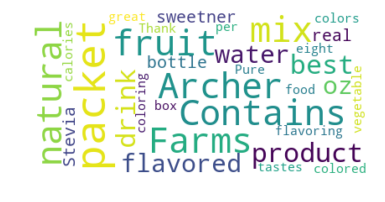

Review- 2 , Review_Index 1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


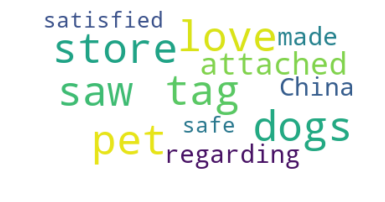

****************************************************************************************************
Cluster- 2
****************************************************************************************************
Review- 1 , Review_Index 131
These freeze dried treats are our dogs favorite treats.  We've been spending DOUBLE the price I paid for them at local area pet stores (ie, Chuck & Don's and PetSmart).  Arrived promptly, well packaged.  Highly recommended.


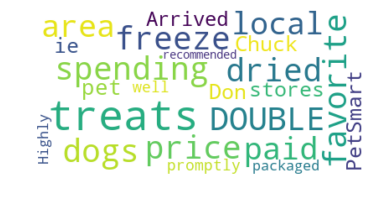

Review- 2 , Review_Index 145
Finally a treat both me and my puppy like. Doesn't have a strong odor, but dogs still love them. Plus, as a freeze-dried treat they don't make your fingers greasy.<br />A healthy treat that my puppy will actually eat!


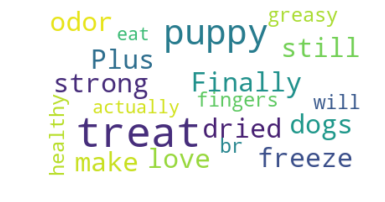

************************* Agglomerative Clustering for Number of Clusters =  3    *************************
****************************************************************************************************
Cluster- 1
****************************************************************************************************
Review- 1 , Review_Index 0
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


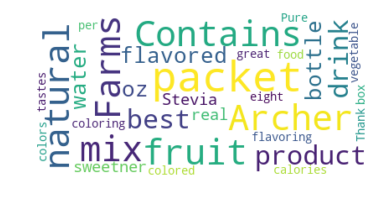

Review- 2 , Review_Index 1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


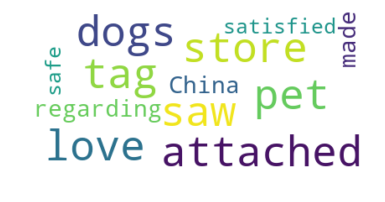

****************************************************************************************************
Cluster- 2
****************************************************************************************************
Review- 1 , Review_Index 131
These freeze dried treats are our dogs favorite treats.  We've been spending DOUBLE the price I paid for them at local area pet stores (ie, Chuck & Don's and PetSmart).  Arrived promptly, well packaged.  Highly recommended.


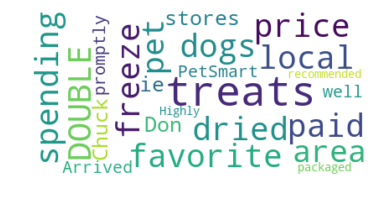

Review- 2 , Review_Index 145
Finally a treat both me and my puppy like. Doesn't have a strong odor, but dogs still love them. Plus, as a freeze-dried treat they don't make your fingers greasy.<br />A healthy treat that my puppy will actually eat!


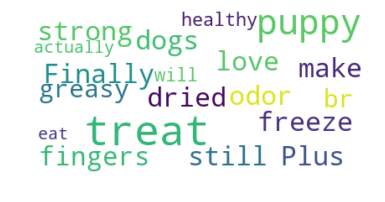

****************************************************************************************************
Cluster- 3
****************************************************************************************************
Review- 1 , Review_Index 223
Just wanted to post a correction to what the previous review said...<br /><br />The film is NOT based on the cartoon it's the other way around. The cartoon came later.


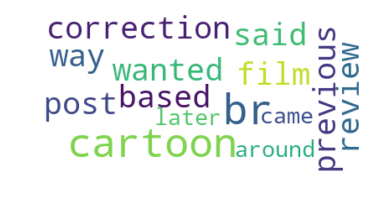

Review- 2 , Review_Index 563
After battling fleas this summer and wanting to know if I had things under control, I purchased 2 flea traps, this one and the Springstar one to see which was the better flea trap.<br /><br />First, the light is very bright so if you plan on using this in a bedroom keep that in mind. It would be better suited to going under the bed.<br /><br />Second, the main difference between the 2 traps is the amount of open space for fleas to get trapped. This trap has a large open space to catch more fleas, and the Spingstar has a smaller grid that traps less fleas. The trade off is, the Springstar is more aesthetically pleasing. That trap hides the trapped fleas better under a grid piece, and kids and pets can't get to the sticky pad. With this trap smaller children could easily reach inside, so again, something to keep in mind.<br /><br />Third, when assembling this trap the sticky pad was curved in the box. This meant that the pad refused to lay flat in the trap. A

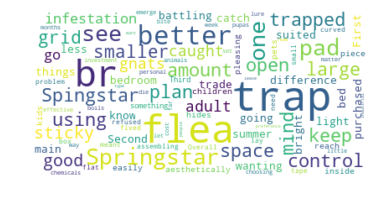

************************* Agglomerative Clustering for Number of Clusters =  5    *************************
****************************************************************************************************
Cluster- 1
****************************************************************************************************
Review- 1 , Review_Index 0
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


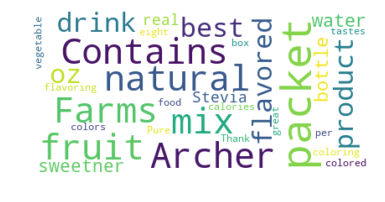

Review- 2 , Review_Index 1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


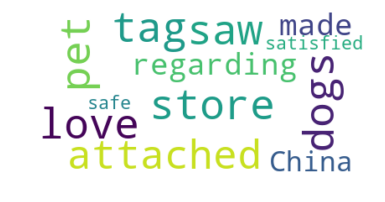

****************************************************************************************************
Cluster- 2
****************************************************************************************************
Review- 1 , Review_Index 131
These freeze dried treats are our dogs favorite treats.  We've been spending DOUBLE the price I paid for them at local area pet stores (ie, Chuck & Don's and PetSmart).  Arrived promptly, well packaged.  Highly recommended.


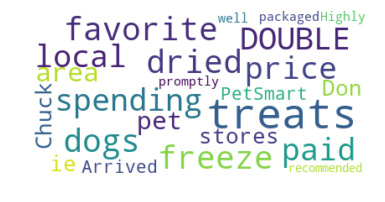

Review- 2 , Review_Index 145
Finally a treat both me and my puppy like. Doesn't have a strong odor, but dogs still love them. Plus, as a freeze-dried treat they don't make your fingers greasy.<br />A healthy treat that my puppy will actually eat!


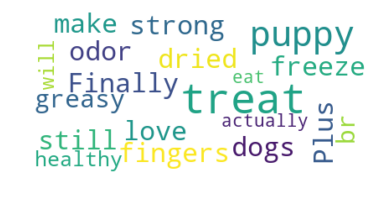

****************************************************************************************************
Cluster- 3
****************************************************************************************************
Review- 1 , Review_Index 223
Just wanted to post a correction to what the previous review said...<br /><br />The film is NOT based on the cartoon it's the other way around. The cartoon came later.


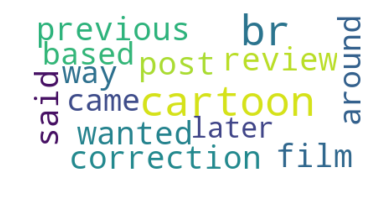

Review- 2 , Review_Index 563
After battling fleas this summer and wanting to know if I had things under control, I purchased 2 flea traps, this one and the Springstar one to see which was the better flea trap.<br /><br />First, the light is very bright so if you plan on using this in a bedroom keep that in mind. It would be better suited to going under the bed.<br /><br />Second, the main difference between the 2 traps is the amount of open space for fleas to get trapped. This trap has a large open space to catch more fleas, and the Spingstar has a smaller grid that traps less fleas. The trade off is, the Springstar is more aesthetically pleasing. That trap hides the trapped fleas better under a grid piece, and kids and pets can't get to the sticky pad. With this trap smaller children could easily reach inside, so again, something to keep in mind.<br /><br />Third, when assembling this trap the sticky pad was curved in the box. This meant that the pad refused to lay flat in the trap. A

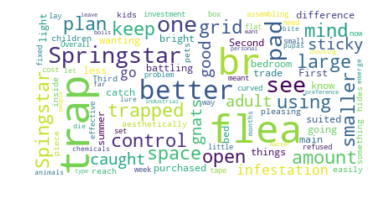

****************************************************************************************************
Cluster- 4
****************************************************************************************************
Review- 1 , Review_Index 97
Freeze dried liver has a hypnotic effect on dogs.  They LOVE it and will do just about anything for it, so it is a great treat to use for training.  (Powdered freeze dried liver is even added to many dog medicines nowadays-- heartworm and arthritis tablets, etc.-- because it causes the dog to scarf the medicine down like a treat.)<br /><br />Freeze dried liver has a dry, hard, yet powdery/easy to chew consistency.  It comes chopped/cubed.  It is extremely lightweight due to the fact there is so little moisture in the product (thus the low weights on product labels).<br /><br />Even though your dog will love liver treats, you shouldn't overfeed it.  The manufacturer recommends 1-2 cubes daily for small dogs, 2-3 cubes for medium dogs, and 3-4 cubes f

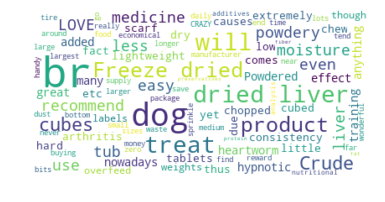

Review- 2 , Review_Index 142
Gold standard for training treats. Have used for 10 years of training. Never met a dog that didn't love them.  Fast easy service thru Amazon sellers.


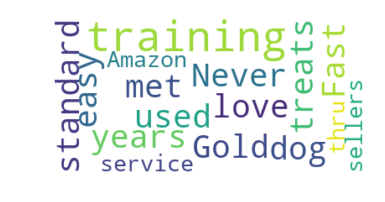

****************************************************************************************************
Cluster- 5
****************************************************************************************************
Review- 1 , Review_Index 10
This is the only dog treat that my terrier will eat. We crumble over his dry food and he LOVES it.


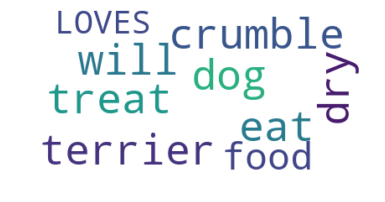

Review- 2 , Review_Index 55
I have a 2 1/2 year old black lab and these are her favorite treats! They are the best for training, my dog will do just about anything to get one of these treats. Even my 3 month old black lab puppy goes running to his kennel when I tell him to go to bed because he knows that a liver treat is coming his way. Since they are sliced small a large container of these will last a while. The only complaint I have is that my dog loves these so much that if she knows shes getting one she starts to drool, and she's not a drooler... So I gotta toss one to her quick!!


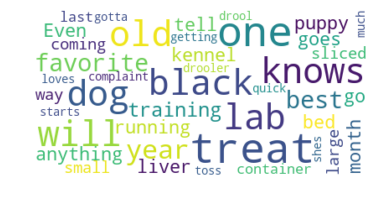

In [22]:
from sklearn.cluster import AgglomerativeClustering

n_cluster_list=[2,3,5]
text_reviews = final['Text'].values

for cluster in n_cluster_list:
    agg_clustering = AgglomerativeClustering(n_clusters = cluster , affinity = 'euclidean' , linkage = 'ward').fit(X_bow.toarray())
    labels = agg_clustering.labels_
    print('*'*25 , "Agglomerative Clustering for Number of Clusters = ", cluster, "  ", "*" * 25)
    
    for i in range(cluster):
        review_count = 1
        print('*'*100)
        print('Cluster-' , i + 1)
        print("*"*100)
        for j in range(labels.shape[0]):
            if labels[j] == i:
                if review_count == 3:
                    break
                else:
                    print('Review-',review_count ,',' , 'Review_Index' , j )
                    print(text_reviews[j])
                    cluster_wordcloud(text_reviews[j])
                    review_count+=1
                

# Agglomerative Clustering on TF-idf vector  :

In [23]:
#Uni Gram  Train dataset Tf-IDF Vector:
tfidf_vector = TfidfVectorizer(min_df=10 )
X_tfidf= tfidf_vector.fit_transform(X)

print('X_tfidf.get_shape() : ' , X_tfidf.get_shape())

X_tfidf.get_shape() :  (5000, 1971)


****************************** Agglomerative Clustering for the Number of Clusters =  2    ******************************
****************************************************************************************************
Cluster- 1
****************************************************************************************************
Review- 1 , Review_Index 0
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


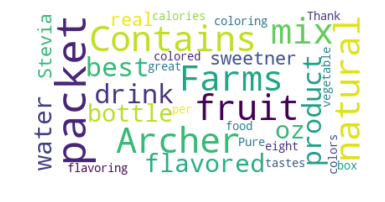

Review- 2 , Review_Index 1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


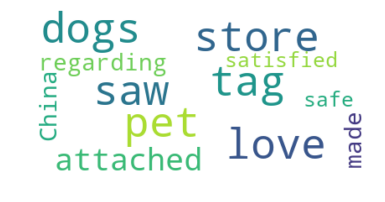

****************************************************************************************************
Cluster- 2
****************************************************************************************************
Review- 1 , Review_Index 68
I was introduced to these treats when I took my dogs to the vet, and saw her giving them these treats.<br />The dogs went crazy for them!<br />Not only that, but there is nothing in this but pure liver.  No added salt, etc....<br /><br />Healthy treats that my dogs love.  And the price is right, too!


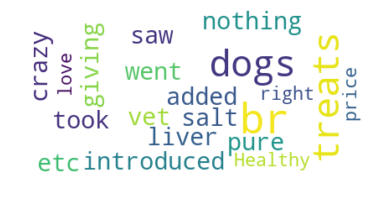

Review- 2 , Review_Index 95
Love this faucet.  My husband had installed the same one in our old house so when our current faucet was leaking I told him not to fix it and we would buy the same one.  It was easy enough for him to install but he did need my assistance a few times to help hold some things in place. Looks great and works great.


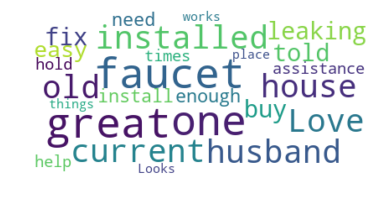

****************************** Agglomerative Clustering for the Number of Clusters =  3    ******************************
****************************************************************************************************
Cluster- 1
****************************************************************************************************
Review- 1 , Review_Index 0
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


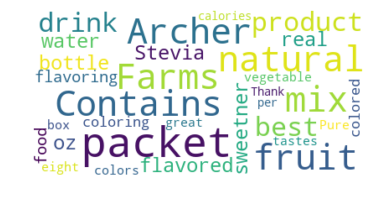

Review- 2 , Review_Index 1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


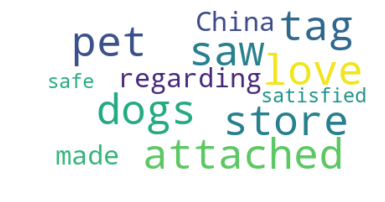

****************************************************************************************************
Cluster- 2
****************************************************************************************************
Review- 1 , Review_Index 68
I was introduced to these treats when I took my dogs to the vet, and saw her giving them these treats.<br />The dogs went crazy for them!<br />Not only that, but there is nothing in this but pure liver.  No added salt, etc....<br /><br />Healthy treats that my dogs love.  And the price is right, too!


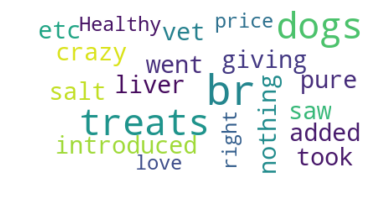

Review- 2 , Review_Index 95
Love this faucet.  My husband had installed the same one in our old house so when our current faucet was leaking I told him not to fix it and we would buy the same one.  It was easy enough for him to install but he did need my assistance a few times to help hold some things in place. Looks great and works great.


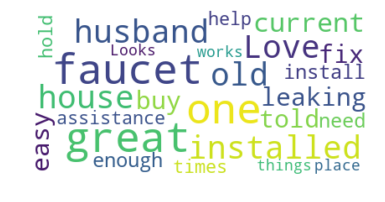

****************************************************************************************************
Cluster- 3
****************************************************************************************************
Review- 1 , Review_Index 6
This was the only treat my dog liked during obedience training and it has remained her favorite ever since.  I haven't met a dog that didn't like this treat!


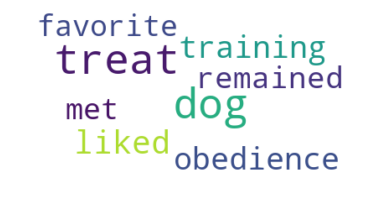

Review- 2 , Review_Index 7
No waste , even if she is having a  day when she goes on a hunger strike  she always room for one or 2 or 3 of these and the extra powder on bottom makes a real treat on food , Never met a pooch that did not go crazy over her treats !


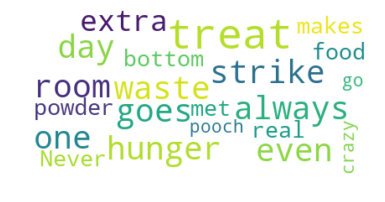

****************************** Agglomerative Clustering for the Number of Clusters =  5    ******************************
****************************************************************************************************
Cluster- 1
****************************************************************************************************
Review- 1 , Review_Index 6
This was the only treat my dog liked during obedience training and it has remained her favorite ever since.  I haven't met a dog that didn't like this treat!


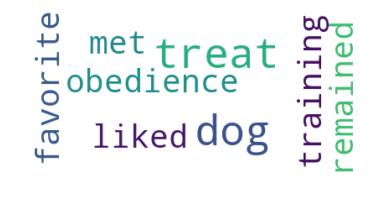

Review- 2 , Review_Index 7
No waste , even if she is having a  day when she goes on a hunger strike  she always room for one or 2 or 3 of these and the extra powder on bottom makes a real treat on food , Never met a pooch that did not go crazy over her treats !


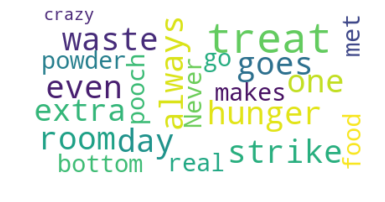

****************************************************************************************************
Cluster- 2
****************************************************************************************************
Review- 1 , Review_Index 5
This is the ONLY dog treat that my Lhasa Apso will eat. It makes me happ becuase it has NO added ingredients or preservatives, as well as NO ADDED SALT! This is the ONLY dog treat that my Vet approves of!


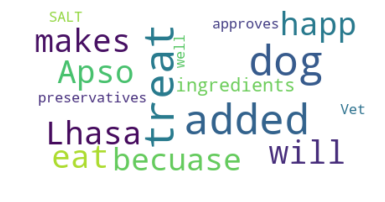

Review- 2 , Review_Index 10
This is the only dog treat that my terrier will eat. We crumble over his dry food and he LOVES it.


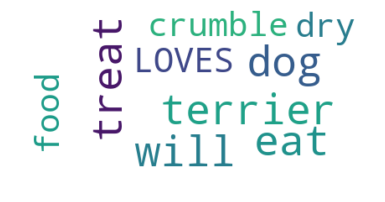

****************************************************************************************************
Cluster- 3
****************************************************************************************************
Review- 1 , Review_Index 0
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


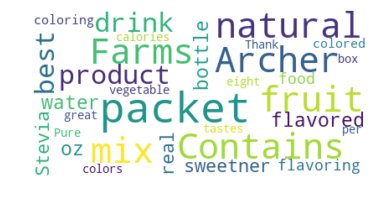

Review- 2 , Review_Index 1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


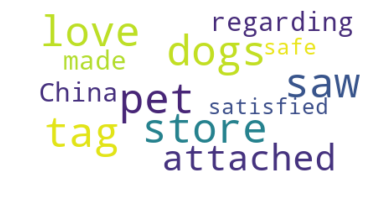

****************************************************************************************************
Cluster- 4
****************************************************************************************************
Review- 1 , Review_Index 68
I was introduced to these treats when I took my dogs to the vet, and saw her giving them these treats.<br />The dogs went crazy for them!<br />Not only that, but there is nothing in this but pure liver.  No added salt, etc....<br /><br />Healthy treats that my dogs love.  And the price is right, too!


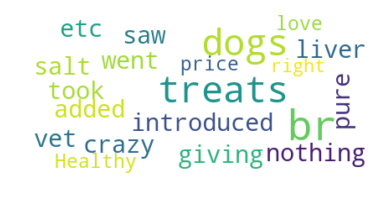

Review- 2 , Review_Index 95
Love this faucet.  My husband had installed the same one in our old house so when our current faucet was leaking I told him not to fix it and we would buy the same one.  It was easy enough for him to install but he did need my assistance a few times to help hold some things in place. Looks great and works great.


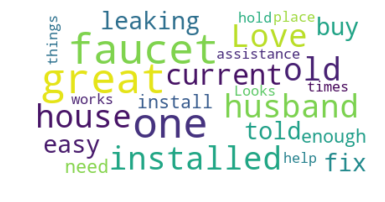

****************************************************************************************************
Cluster- 5
****************************************************************************************************
Review- 1 , Review_Index 71
My dog loves these and so do I : ).  No yucky texture or greasy feel such as with hot dog pieces or cheese pieces and no grossness in your pocket or treat bag.  And my dog will do a lot for a taste of these treats.


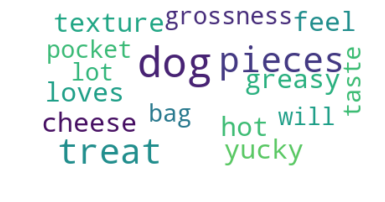

Review- 2 , Review_Index 73
When I first go my Havanese puppy 1 1/2 years ago, the breeder suggested these liver treats for using when training.  My dog will do ANYTHING for these treats.  They even use them at the name brand pet hotel we use in Phoenix.  You have to be careful not to give too much, but my dog, Tanner, got over his separation anxiety when I started the routine of asking for a kiss, then giving him a treat and then leaving.  Now he just wants the treat, I have to beg for the kiss.


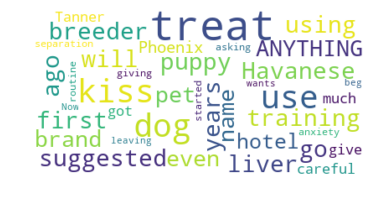

In [24]:
from sklearn.cluster import AgglomerativeClustering

n_cluster_list=[2,3,5]
text_reviews = final['Text'].values

for cluster in n_cluster_list:
    agg_clustering = AgglomerativeClustering(n_clusters = cluster , affinity = 'euclidean' , linkage = 'ward').fit(X_tfidf.toarray())
    labels = agg_clustering.labels_
    print('*'*30 , "Agglomerative Clustering for the Number of Clusters = ", cluster, "  ", "*" * 30)
    
    for i in range(cluster):
        review_count = 1
        print('*'*100)
        print('Cluster-' , i + 1)
        print("*"*100)
        for j in range(labels.shape[0]):
            if labels[j] == i:
                if review_count == 3:
                    break
                else:
                    print('Review-',review_count ,',' , 'Review_Index' , j )
                    print(text_reviews[j])
                    cluster_wordcloud(text_reviews[j])
                    review_count+=1
                

## Word2Vec

In [20]:
# Lets compute a list of words for Train Data to compute the word2vec:
# Now we will Train our own model using Word2vec:
list_of_sentence=[]
for sent in X:
    list_of_sentence.append(sent.split())

print(list_of_sentence[0])

['beetlejuic', 'well', 'written', 'movi', 'everyth', 'excel', 'act', 'special', 'effect', 'delight', 'chose', 'view', 'movi']


In [21]:
# Creating the gensim model
import gensim
import warnings
warnings.filterwarnings('ignore')

model = gensim.models.Word2Vec(list_of_sentence , min_count=5 , size=200 , workers=4)
vocab_list = list(model.wv.vocab)

In [22]:
#Computing the Average word2vec for Data:
sent_vect= [] #this will hold the all values of the vectors of each words
for sen in tqdm(list_of_sentence):
    sen_vec = np.zeros(200) 
    word_count=0
    for word in sen:
        if word in vocab_list:
            vector_of_current_word = model.wv[word]
            sen_vec+=vector_of_current_word
            word_count+=1
    if word_count != 0:
        sen_vec/=word_count
    sent_vect.append(sen_vec)

print(len(sent_vect))

print(len(sent_vect[0]))
        

100%|█████████████████████████████████████| 5000/5000 [00:18<00:00, 266.15it/s]


5000
200


In [23]:
sent_vect = np.array(sent_vect)
type(sent_vect)

numpy.ndarray

************************* Agglomerative Clustering for Number of Clusters =  2    *************************
****************************************************************************************************
Cluster- 1
****************************************************************************************************
Review- 1 , Review_Index 0
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


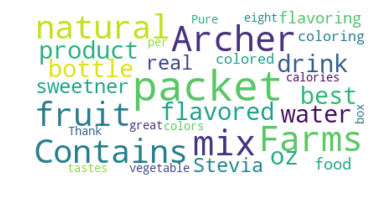

Review- 2 , Review_Index 1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


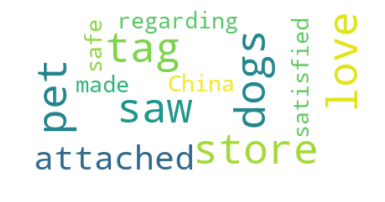

****************************************************************************************************
Cluster- 2
****************************************************************************************************
Review- 1 , Review_Index 21
Freeze dried liver has a hypnotic effect on dogs. They LOVE it and will do just about anything for it, so it is a great treat to use for training. (Powdered freeze dried liver is even added to many dog medicines nowadays-- heartworm and arthritis tablets, etc.-- because it causes the dog to scarf the medicine down like a treat.)<br /><br />Freeze dried liver has a dry, hard, yet powdery/easy to chew consistency. It comes chopped/cubed. It is extremely lightweight due to the fact there is so little moisture in the product (thus the low weights on product labels).<br /><br />Even though your dog will love liver treats, you shouldn't overfeed it. The manufacturer recommends 1-2 cubes daily for small dogs, 2-3 cubes for medium dogs, and 3-4 cubes for la

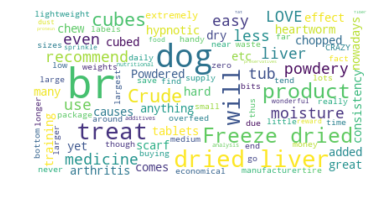

Review- 2 , Review_Index 34
This is 2.5 oz larger than what you can find in pet stores and less expensive. Shipped day the it was ordered and arrived 2 days later with prime.


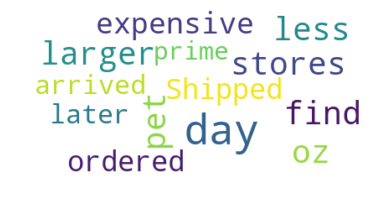

************************* Agglomerative Clustering for Number of Clusters =  3    *************************
****************************************************************************************************
Cluster- 1
****************************************************************************************************
Review- 1 , Review_Index 0
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


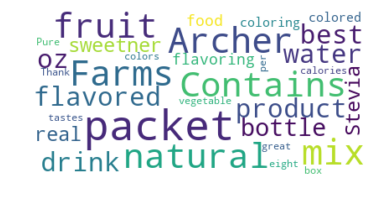

Review- 2 , Review_Index 1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


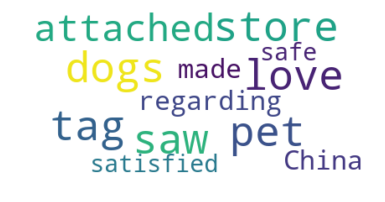

****************************************************************************************************
Cluster- 2
****************************************************************************************************
Review- 1 , Review_Index 21
Freeze dried liver has a hypnotic effect on dogs. They LOVE it and will do just about anything for it, so it is a great treat to use for training. (Powdered freeze dried liver is even added to many dog medicines nowadays-- heartworm and arthritis tablets, etc.-- because it causes the dog to scarf the medicine down like a treat.)<br /><br />Freeze dried liver has a dry, hard, yet powdery/easy to chew consistency. It comes chopped/cubed. It is extremely lightweight due to the fact there is so little moisture in the product (thus the low weights on product labels).<br /><br />Even though your dog will love liver treats, you shouldn't overfeed it. The manufacturer recommends 1-2 cubes daily for small dogs, 2-3 cubes for medium dogs, and 3-4 cubes for la

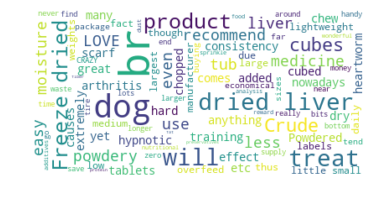

Review- 2 , Review_Index 34
This is 2.5 oz larger than what you can find in pet stores and less expensive. Shipped day the it was ordered and arrived 2 days later with prime.


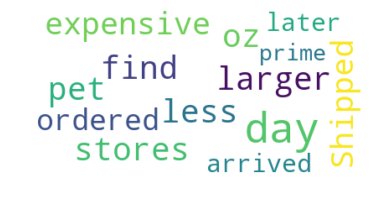

****************************************************************************************************
Cluster- 3
****************************************************************************************************
Review- 1 , Review_Index 5
This is the ONLY dog treat that my Lhasa Apso will eat. It makes me happ becuase it has NO added ingredients or preservatives, as well as NO ADDED SALT! This is the ONLY dog treat that my Vet approves of!


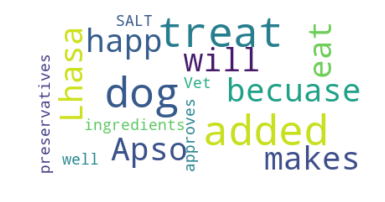

Review- 2 , Review_Index 10
This is the only dog treat that my terrier will eat. We crumble over his dry food and he LOVES it.


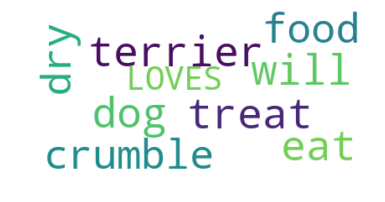

************************* Agglomerative Clustering for Number of Clusters =  5    *************************
****************************************************************************************************
Cluster- 1
****************************************************************************************************
Review- 1 , Review_Index 11
New puppy loves this, only treat he will pay attention to while walking and training. One note, pieces are quite large so I cut them up into smaller pieces so their recommended daily amount goes further.<br /><br />All the dogs in the dog park can't resist my pocket when I have these treats. Usually surrounded by a crowd of dogs all poking at my pocket.


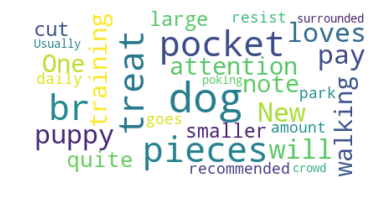

Review- 2 , Review_Index 14
We were buying thses from our vet, but they are so expensive. So glad we found them online.  Our dog loves these! Thanks!


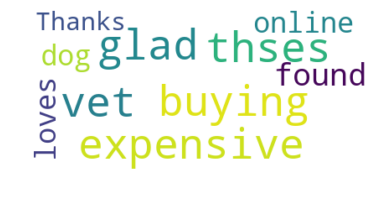

****************************************************************************************************
Cluster- 2
****************************************************************************************************
Review- 1 , Review_Index 0
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


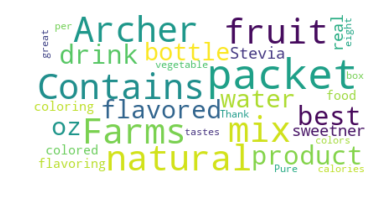

Review- 2 , Review_Index 1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


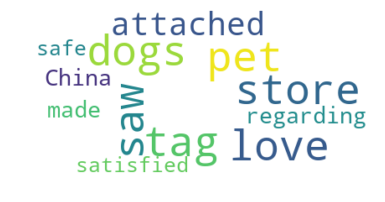

****************************************************************************************************
Cluster- 3
****************************************************************************************************
Review- 1 , Review_Index 5
This is the ONLY dog treat that my Lhasa Apso will eat. It makes me happ becuase it has NO added ingredients or preservatives, as well as NO ADDED SALT! This is the ONLY dog treat that my Vet approves of!


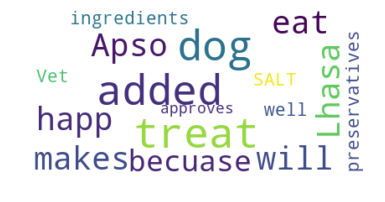

Review- 2 , Review_Index 10
This is the only dog treat that my terrier will eat. We crumble over his dry food and he LOVES it.


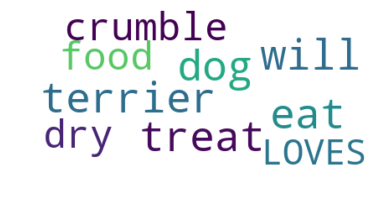

****************************************************************************************************
Cluster- 4
****************************************************************************************************
Review- 1 , Review_Index 21
Freeze dried liver has a hypnotic effect on dogs. They LOVE it and will do just about anything for it, so it is a great treat to use for training. (Powdered freeze dried liver is even added to many dog medicines nowadays-- heartworm and arthritis tablets, etc.-- because it causes the dog to scarf the medicine down like a treat.)<br /><br />Freeze dried liver has a dry, hard, yet powdery/easy to chew consistency. It comes chopped/cubed. It is extremely lightweight due to the fact there is so little moisture in the product (thus the low weights on product labels).<br /><br />Even though your dog will love liver treats, you shouldn't overfeed it. The manufacturer recommends 1-2 cubes daily for small dogs, 2-3 cubes for medium dogs, and 3-4 cubes for la

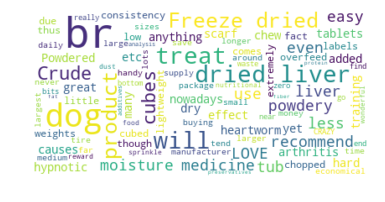

Review- 2 , Review_Index 34
This is 2.5 oz larger than what you can find in pet stores and less expensive. Shipped day the it was ordered and arrived 2 days later with prime.


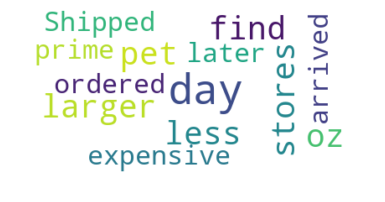

****************************************************************************************************
Cluster- 5
****************************************************************************************************
Review- 1 , Review_Index 148
I was pet sitting recently and the dog I was sitting for had these in her treat pouch. She loved them so I tried them with my dogs. All 3 dogs were quite well-behaved whenever they saw me reach for these goodies. My son and I jokingly call them "doggie crack". They're good for them, they work as training tools, what else can you ask for in a dog treat?


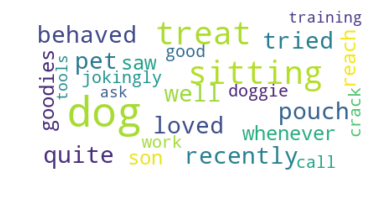

Review- 2 , Review_Index 154
I selected this company over the other even though the price was higher. I was hoping the pieces would be more consistent in size. It tuened out the container was filled with smaller crum like pieces, worse than the other company's. I will never buy anything from this company.


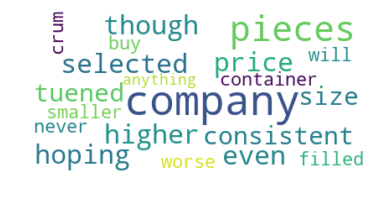

In [26]:
from sklearn.cluster import AgglomerativeClustering

n_cluster_list=[2,3,5]
text_reviews = final['Text'].values

for cluster in n_cluster_list:
    agg_clustering = AgglomerativeClustering(n_clusters = cluster , affinity = 'euclidean' , linkage = 'ward').fit(sent_vect)
    labels = agg_clustering.labels_
    print('*'*25 , "Agglomerative Clustering for Number of Clusters = ", cluster, "  ", "*" * 25)
    
    for i in range(cluster):
        review_count = 1
        print('*'*100)
        print('Cluster-' , i + 1)
        print("*"*100)
        for j in range(labels.shape[0]):
            if labels[j] == i:
                if review_count == 3:
                    break
                else:
                    print('Review-',review_count ,',' , 'Review_Index' , j )
                    print(text_reviews[j])
                    cluster_wordcloud(text_reviews[j])
                    review_count+=1
                

# TF-idf W2vec :

In [27]:
#Computing the TF-idf values for the Train Data:
tfidf_model = TfidfVectorizer()
tf_idf_matrix = tfidf_model.fit_transform(X)

# we are converting a dictionary with word as a key, and the tfidf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

In [28]:
# Creating the gensim model
model = gensim.models.Word2Vec(list_of_sentence , min_count=5 , size=200 , workers=4)
vocab_list = list(model.wv.vocab)

In [29]:
# TF-IDF weighted Word2Vec
tfidf_feat = tfidf_model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentence): # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab_list:
            vec = model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
    
print('\n' , len(tfidf_sent_vectors))

print(len(tfidf_sent_vectors[0]))

100%|█████████████████████████████████████| 5000/5000 [00:16<00:00, 301.28it/s]



 5000
200


In [30]:
#Converting the type of tfidf_sent_vectors_train to ndarray:
tfidf_sent_vectors = np.array(tfidf_sent_vectors)
type(tfidf_sent_vectors)

numpy.ndarray

************************* Agglomerative Clustering for Number of Clusters =  2    *************************
****************************************************************************************************
Cluster- 1
****************************************************************************************************
Review- 1 , Review_Index 0
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


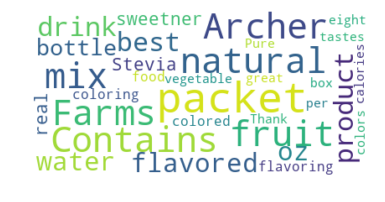

Review- 2 , Review_Index 1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


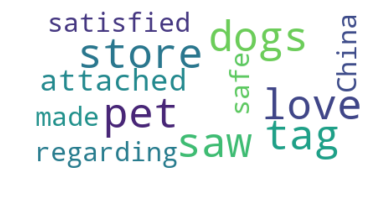

****************************************************************************************************
Cluster- 2
****************************************************************************************************
Review- 1 , Review_Index 60
Pros:<br />Dog will do anything for this treat.<br />Doesn't smell as bad as many other treats.<br />Easy to break into smaller pieces.<br />Nothing artificial, easy digestion.<br /><br />Cons:<br />More costly than other dog treats.<br /><br />Overall, this is a great product. While more expensive, my dog will do anything for this treat. He has several phobias, including getting in and out of the car, and walking through doorways, but he ignores all of his fears to get to this treat.


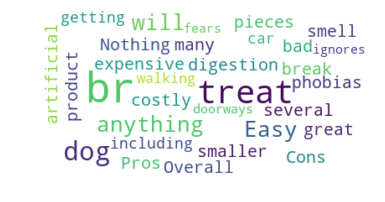

Review- 2 , Review_Index 68
I was introduced to these treats when I took my dogs to the vet, and saw her giving them these treats.<br />The dogs went crazy for them!<br />Not only that, but there is nothing in this but pure liver.  No added salt, etc....<br /><br />Healthy treats that my dogs love.  And the price is right, too!


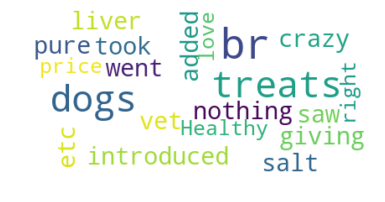

************************* Agglomerative Clustering for Number of Clusters =  3    *************************
****************************************************************************************************
Cluster- 1
****************************************************************************************************
Review- 1 , Review_Index 0
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


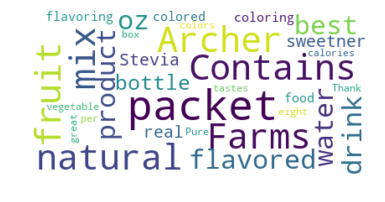

Review- 2 , Review_Index 1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


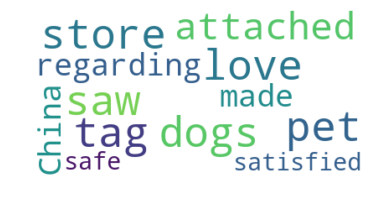

****************************************************************************************************
Cluster- 2
****************************************************************************************************
Review- 1 , Review_Index 60
Pros:<br />Dog will do anything for this treat.<br />Doesn't smell as bad as many other treats.<br />Easy to break into smaller pieces.<br />Nothing artificial, easy digestion.<br /><br />Cons:<br />More costly than other dog treats.<br /><br />Overall, this is a great product. While more expensive, my dog will do anything for this treat. He has several phobias, including getting in and out of the car, and walking through doorways, but he ignores all of his fears to get to this treat.


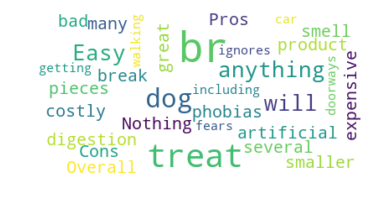

Review- 2 , Review_Index 68
I was introduced to these treats when I took my dogs to the vet, and saw her giving them these treats.<br />The dogs went crazy for them!<br />Not only that, but there is nothing in this but pure liver.  No added salt, etc....<br /><br />Healthy treats that my dogs love.  And the price is right, too!


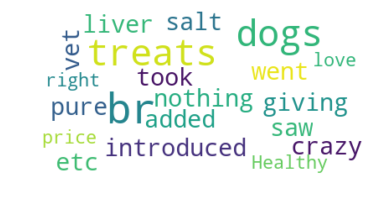

****************************************************************************************************
Cluster- 3
****************************************************************************************************
Review- 1 , Review_Index 5
This is the ONLY dog treat that my Lhasa Apso will eat. It makes me happ becuase it has NO added ingredients or preservatives, as well as NO ADDED SALT! This is the ONLY dog treat that my Vet approves of!


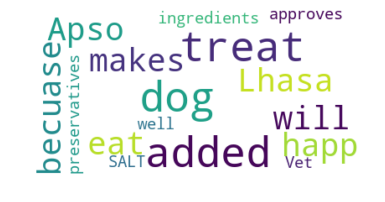

Review- 2 , Review_Index 10
This is the only dog treat that my terrier will eat. We crumble over his dry food and he LOVES it.


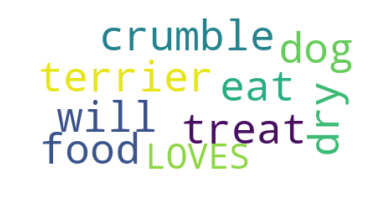

************************* Agglomerative Clustering for Number of Clusters =  5    *************************
****************************************************************************************************
Cluster- 1
****************************************************************************************************
Review- 1 , Review_Index 0
This product by Archer Farms is the best drink mix ever. Just mix a flavored packet with your 16 oz. water bottle. Contains the all natural sweetner Stevia, real fruit flavoring and no food coloring. Just colored with fruit or vegetable colors. Pure and natural and tastes great. There are eight packets in a box and only contains 10 calories per packet. Thank you Archer Farms!


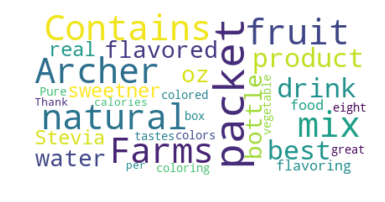

Review- 2 , Review_Index 1
Our dogs just love them.  I saw them in a pet store and a tag was attached regarding them being made in China and it satisfied me that they were safe.


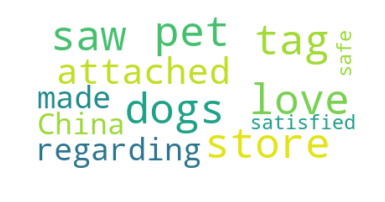

****************************************************************************************************
Cluster- 2
****************************************************************************************************
Review- 1 , Review_Index 145
Finally a treat both me and my puppy like. Doesn't have a strong odor, but dogs still love them. Plus, as a freeze-dried treat they don't make your fingers greasy.<br />A healthy treat that my puppy will actually eat!


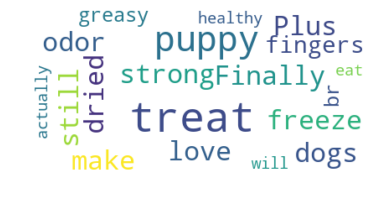

Review- 2 , Review_Index 159
This sly trap is attractive to look at, works well, and has no odor. I recommend it!


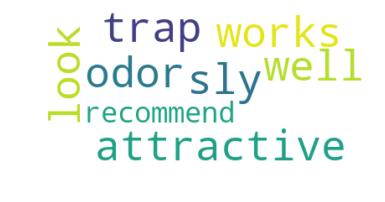

****************************************************************************************************
Cluster- 3
****************************************************************************************************
Review- 1 , Review_Index 5
This is the ONLY dog treat that my Lhasa Apso will eat. It makes me happ becuase it has NO added ingredients or preservatives, as well as NO ADDED SALT! This is the ONLY dog treat that my Vet approves of!


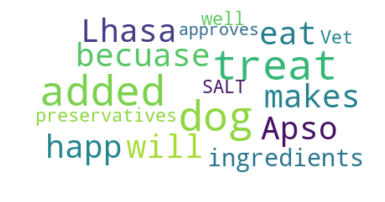

Review- 2 , Review_Index 10
This is the only dog treat that my terrier will eat. We crumble over his dry food and he LOVES it.


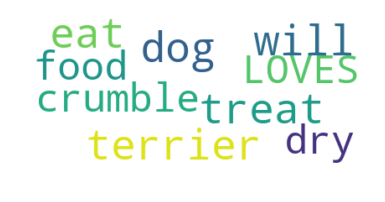

****************************************************************************************************
Cluster- 4
****************************************************************************************************
Review- 1 , Review_Index 60
Pros:<br />Dog will do anything for this treat.<br />Doesn't smell as bad as many other treats.<br />Easy to break into smaller pieces.<br />Nothing artificial, easy digestion.<br /><br />Cons:<br />More costly than other dog treats.<br /><br />Overall, this is a great product. While more expensive, my dog will do anything for this treat. He has several phobias, including getting in and out of the car, and walking through doorways, but he ignores all of his fears to get to this treat.


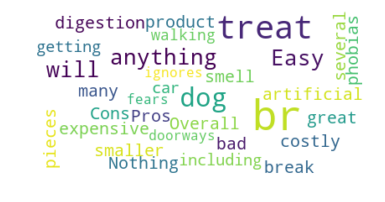

Review- 2 , Review_Index 68
I was introduced to these treats when I took my dogs to the vet, and saw her giving them these treats.<br />The dogs went crazy for them!<br />Not only that, but there is nothing in this but pure liver.  No added salt, etc....<br /><br />Healthy treats that my dogs love.  And the price is right, too!


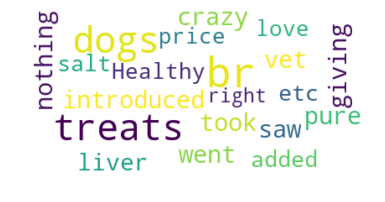

****************************************************************************************************
Cluster- 5
****************************************************************************************************
Review- 1 , Review_Index 92
ALL I DO IS SHAKE THIS CONTAINER AND MY DOG COMES RUNNING. SHE HAS HAD FOR OVER A YEAR AND PREFERS TO ALL TREATS AND FOOD. I FEEL GREAT AS THEY ARE GOOD FOR HER. THE PRICE SEEMS HEFTY BUT YOU CAN CUT THE PIECES UP EVEN THOUGH FREEZE DRIED. OUR FAV DOG TREAT FOR SURE. MAKES YOU FEEL GREAT TO GIVE YOUR PUP A EXCELLENT SOURCE OF ALL NUTRIENTS THEY LOVE. I FEEL LIKE I'M TRICKING HER.


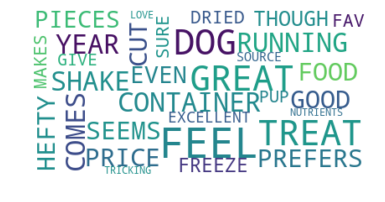

Review- 2 , Review_Index 94
Gimborn Freeze Dried Treats 21 oz Beef Liver is one of my dog's favorite treats, so I was happy to find them in a large size container. I received my order very quickly, and was happy with the service I received.


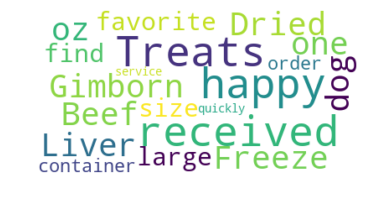

In [31]:
from sklearn.cluster import AgglomerativeClustering

n_cluster_list=[2,3,5]
text_reviews = final['Text'].values

for cluster in n_cluster_list:
    agg_clustering = AgglomerativeClustering(n_clusters = cluster , affinity = 'euclidean' , linkage = 'ward').fit(tfidf_sent_vectors)
    labels = agg_clustering.labels_
    print('*'*25 , "Agglomerative Clustering for Number of Clusters = ", cluster, "  ", "*" * 25)
    
    for i in range(cluster):
        review_count = 1
        print('*'*100)
        print('Cluster-' , i + 1)
        print("*"*100)
        for j in range(labels.shape[0]):
            if labels[j] == i:
                if review_count == 3:
                    break
                else:
                    print('Review-',review_count ,',' , 'Review_Index' , j )
                    print(text_reviews[j])
                    cluster_wordcloud(text_reviews[j])
                    review_count+=1
                